### Necessary Packages

In [1]:
import sys
import os
import torch
import pandas as pd
sys.path.append('../..')
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from src.utils import load, load_checkpoint, seed_everything, score
from src.training.cnn_k_fold import create_dataloaders,create_network,Config
from src.models import ResNet
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,auc,roc_curve,roc_auc_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from definitions import *
from functools import reduce

### Global

In [2]:
EXPIREMENT_NAME = 'vit_small'
EXPIREMENT_PATH = os.path.join(EXPIREMENTS_DIR,EXPIREMENT_NAME)
CHECKPOINTS_PATH = os.path.join(EXPIREMENT_PATH,'checkpoints')
CONFIG_PATH = os.path.join(EXPIREMENT_PATH,'config.json')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load configurations

In [3]:
config = Config(**load(CONFIG_PATH))
loaders,test_loader = create_dataloaders(config)

### Reproducibility

In [4]:
seed_everything(config.seed)

### Models loading

In [5]:
def create_models(checkpoints_path : str):

    models = []
    files = sorted(os.listdir(CHECKPOINTS_PATH), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    for i,checkpoint in enumerate(tqdm(files)):

        model = create_network(config)
        checkpoint = load_checkpoint(os.path.join(checkpoints_path, checkpoint), f'checkpoint_fold={i}.pt')
        model.load_state_dict(checkpoint['model'])
        model.to(DEVICE)
        model.eval()
        models.append(model)

    return models

In [6]:
models = create_models(CHECKPOINTS_PATH)

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (tim

In [7]:
### Save the models
for i,model in enumerate(models):
    torch.save(model.state_dict(),os.path.join(EXPIREMENT_PATH,f'model_fold={i}.pth'))

### Make predictions on individual folds

In [7]:
def predict(model: ResNet, dataloader: DataLoader):

    model.eval()

    y_true = []
    y_pred = []

    for x,y in tqdm(dataloader):

        x = x.to(DEVICE)
        y_hat = model.predict(x).detach().cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(y_hat)

    return y_true,y_pred

In [8]:
def predict_all(models: list, dataloaders: list[DataLoader] | DataLoader):
    
    results = {}

    for i,model in enumerate(models):

        if isinstance(dataloaders,list):
            dataloader = dataloaders[i]
        else:
            dataloader = dataloaders

        y_true,y_pred = predict(model,dataloader)

        results[f'fold_{i}'] = pd.DataFrame({
            'y_true': y_true,
            'y_pred': y_pred
        })

    return results

In [9]:
result = predict_all(models,list((val_loader for _,val_loader in loaders)))

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [10]:
result['fold_0'].head()

,y_true,y_pred
0,0.0,0.000067
1,0.0,0.000071
2,0.0,0.000806
3,0.0,0.000331
4,0.0,0.000023


### Calculate Fold-metrics

In [11]:
def calculate_metrics(y_true : np.ndarray,y_hard : np.ndarray,y_prob : np.ndarray) -> pd.Series:

    accuracy = accuracy_score(y_true,y_hard)
    f1 = f1_score(y_true,y_hard)
    precision = precision_score(y_true,y_hard)
    recall = recall_score(y_true,y_hard)
    roc_auc = roc_auc_score(y_true,y_prob)
    pauc = score(y_true,y_prob)

    results = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'pauc': pauc
    }

    return pd.Series(results)

In [12]:
def calculate_all_metrics(result: dict[str,pd.DataFrame]) -> pd.DataFrame:

    metrics = []

    for fold in result.keys():

        y_true = result[fold]['y_true']
        y_pred = np.int32(result[fold]['y_pred'] > 0.5)
        y_prob = result[fold]['y_pred']

        fold_result = calculate_metrics(y_true,y_pred,y_prob)
        fold_result.name = fold

        metrics.append(fold_result)

    metrics = pd.DataFrame(metrics)

    means = metrics.mean(axis=0)
    stds = metrics.std(axis=0)
    metrics.loc['mean'] = means
    metrics.loc['std'] = stds

    return metrics

In [13]:
fold_metrics = calculate_all_metrics(result)

In [14]:
fold_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.988511,0.047146,0.025503,0.311475,0.918727,0.145997
fold_1,0.972458,0.041645,0.021668,0.533333,0.906327,0.124639
fold_2,0.992804,0.062378,0.035165,0.275862,0.886523,0.110365
fold_3,0.977799,0.061947,0.032558,0.636364,0.933015,0.148509
fold_4,0.988825,0.053232,0.028966,0.328125,0.908586,0.135039
mean,0.984079,0.053270,0.028772,0.417032,0.910635,0.132910
std,0.008555,0.009095,0.005394,0.158594,0.017106,0.015778


<Axes: ylabel='pauc'>

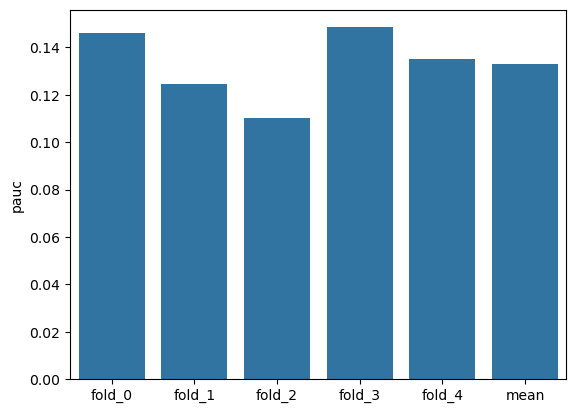

In [15]:
sns.barplot(fold_metrics['pauc'].drop('std'))

### Calculate test-set metrics

In [16]:
test_result = predict_all(models,test_loader)

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [23]:
test_result['fold_0'].head()

,y_true,y_pred
0,0.0,0.003675
1,0.0,0.000035
2,0.0,0.000085
3,0.0,0.000169
4,0.0,0.968970


In [24]:
test_metrics = calculate_all_metrics(test_result)

In [25]:
test_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.983558,0.033421,0.017609,0.327586,0.926495,0.152097
fold_1,0.972398,0.026385,0.013609,0.431034,0.914364,0.145168
fold_2,0.992086,0.063717,0.035503,0.310345,0.925203,0.147167
fold_3,0.981195,0.048448,0.025337,0.551724,0.932786,0.147178
fold_4,0.984157,0.031107,0.016425,0.293103,0.911427,0.137065
mean,0.982679,0.040616,0.021697,0.382759,0.922055,0.145735
std,0.007060,0.015327,0.008857,0.108634,0.008901,0.005480


<Axes: ylabel='pauc'>

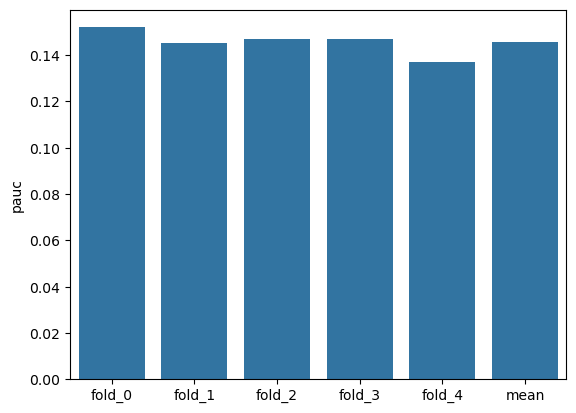

In [26]:
sns.barplot(test_metrics['pauc'].drop('std'))

### The mean of the models

In [27]:
mean = reduce(lambda a,b : a+b,(test_result[key]['y_pred'] for key in test_result.keys())) / len(test_result.keys())

In [28]:
mean_metrcis = calculate_metrics(test_result['fold_0']['y_true'],np.int32(mean > 0.5),mean)
mean_metrcis.name = 'mean'
mean_metrcis

accuracy     0.990186
f1           0.065527
precision    0.035714
recall       0.396552
roc_auc      0.949334
pauc         0.163914
Name: mean, dtype: float64